In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import altair as alt
import shap

from interaction_effects.marginal import MarginalExplainer
from interaction_effects import utils

In [2]:
utils.set_up_environment()

In [3]:
n = 1000
d = 3
batch_size = 50
learning_rate = 0.1

In [4]:
W = np.array([-2.0, -3.0, 1.0])
b = 0.0
X = np.random.randn(n, d)
y = np.dot(X, W) + b

In [5]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(3,), batch_size=batch_size))
model.add(tf.keras.layers.Dense(1, activation=None, use_bias=True))

In [6]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MSE,
              metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])

In [7]:
model.fit(X, y, epochs=10, verbose=2)

Train on 1000 samples
Epoch 1/10
1000/1000 - 1s - loss: 2.8500 - mean_absolute_error: 0.8764 - mean_squared_error: 2.8500
Epoch 2/10
1000/1000 - 0s - loss: 3.9799e-04 - mean_absolute_error: 0.0103 - mean_squared_error: 3.9799e-04
Epoch 3/10
1000/1000 - 0s - loss: 6.6389e-08 - mean_absolute_error: 1.4123e-04 - mean_squared_error: 6.6389e-08
Epoch 4/10
1000/1000 - 0s - loss: 1.3945e-11 - mean_absolute_error: 2.1810e-06 - mean_squared_error: 1.3945e-11
Epoch 5/10
1000/1000 - 0s - loss: 1.4861e-13 - mean_absolute_error: 2.7141e-07 - mean_squared_error: 1.4861e-13
Epoch 6/10
1000/1000 - 0s - loss: 1.3461e-13 - mean_absolute_error: 2.5169e-07 - mean_squared_error: 1.3461e-13
Epoch 7/10
1000/1000 - 0s - loss: 1.3183e-13 - mean_absolute_error: 2.4972e-07 - mean_squared_error: 1.3183e-13
Epoch 8/10
1000/1000 - 0s - loss: 1.3200e-13 - mean_absolute_error: 2.5096e-07 - mean_squared_error: 1.3200e-13
Epoch 9/10
1000/1000 - 0s - loss: 1.0226e-13 - mean_absolute_error: 2.0987e-07 - mean_squared_erro

In [8]:
primal_explainer = MarginalExplainer(model, X[20:], nsamples=800, representation='mobius')
primal_effects = primal_explainer.explain(X[:20], verbose=True)

100%|██████████| 20/20 [00:01<00:00, 16.52it/s]


In [9]:
dual_explainer = MarginalExplainer(model, X[20:], nsamples=800, representation='comobius')
dual_effects = dual_explainer.explain(X[:20], verbose=True)

100%|██████████| 20/20 [00:01<00:00, 16.30it/s]


In [10]:
average_explainer = MarginalExplainer(model, X[20:], nsamples=800, representation='average')
average_effects = average_explainer.explain(X[:20], verbose=True)

100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


In [11]:
shap_values = X * W[np.newaxis, :]

In [12]:
model_func = lambda x: model(x).numpy()
kernel_explainer = shap.SamplingExplainer(model_func, X)
kernel_shap = kernel_explainer.shap_values(X[:20])

In [13]:
data_df = pd.DataFrame({
    'True SHAP Values':        shap_values[:20].flatten(),
    'Sampled Primal Effects':  primal_effects.flatten(),
    'Sampled Dual Effects':    dual_effects.flatten(),
    'Sampled Average Effects': average_effects.flatten(),
    'Kernel SHAP Values':      kernel_shap.flatten()
})

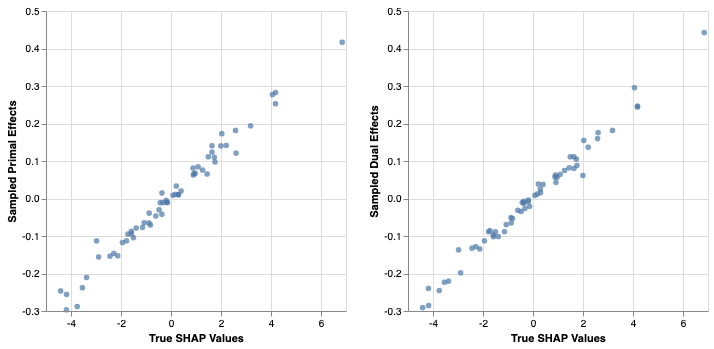

In [14]:
alt.Chart(data_df).mark_point(filled=True).encode(
    alt.X('True SHAP Values:Q'),
    alt.Y(alt.repeat("column"), type='quantitative')
).properties(width=300, height=300).repeat(column=['Sampled Primal Effects', 'Sampled Dual Effects'])

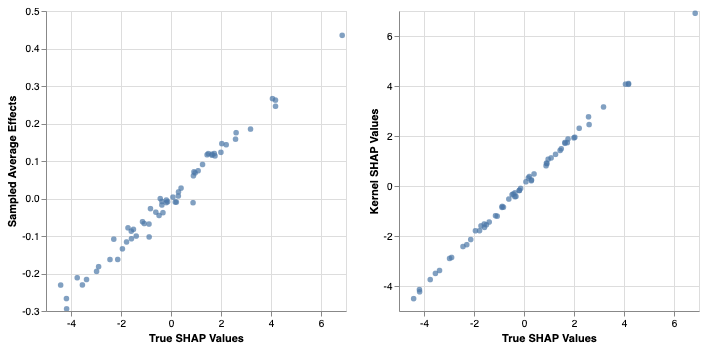

In [15]:
alt.Chart(data_df).mark_point(filled=True).encode(
    alt.X('True SHAP Values:Q'),
    alt.Y(alt.repeat("column"), type='quantitative')
).properties(width=300, height=300).repeat(column=['Sampled Average Effects', 'Kernel SHAP Values'])